In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.isotonic import IsotonicRegression
from pygam import LogisticGAM, s
from scipy.stats import gaussian_kde

In [88]:
input_target = "output/run1/splinePEP/0/peptide.target.txt"
input_decoy = "output/run1/splinePEP/0/peptide.decoy.txt"
columns = ["score", "q-value", "posterior_error_prob"]
df_target = pd.read_csv(input_target, sep="\t", usecols=columns)
df_decoy = pd.read_csv(input_decoy, sep="\t", usecols=columns)
df_target["type"] = int(0)
df_decoy["type"] = int(1)
df = pd.concat([df_target, df_decoy], ignore_index=True)
df = df.rename(columns={"posterior_error_prob": "pep_percspline"})
df = df.sort_values(by='score', ascending=False, ignore_index=True)

pseudo_row = pd.DataFrame({
    "score": [np.nan],
    "q-value": [np.nan],
    "pep_percspline": [np.nan],
    "type": [0.5]
})
df_pseudo = pd.concat([pseudo_row, df], ignore_index=True)

x_pseudo = np.array(range(len(df_pseudo["score"])))
y_pseudo = df_pseudo["type"].values

x = np.array(range(len(df["score"])))
x_2d = x.reshape(-1, 1)
y = df["type"].values

y_series = pd.Series(y)
window_size = 500
y_moving_avg = y_series.rolling(window_size, center=True).mean()

In [89]:
iso_reg = IsotonicRegression(y_max=1.0, y_min=0.0, increasing=True, out_of_bounds="clip")
df_pseudo["decoy_prob_isoreg"] = iso_reg.fit_transform(x_pseudo, y_pseudo)
df["decoy_prob_isoreg"] = df_pseudo["decoy_prob_isoreg"].iloc[1:].reset_index(drop=True)
df["pep_isoreg"] = df["decoy_prob_isoreg"] / (1 - df["decoy_prob_isoreg"])
df["pep_isoreg"] = np.clip(df["pep_isoreg"], 0, 1)

In [90]:
gam = LogisticGAM(s(0, constraints='monotonic_inc')).fit(x_2d, y)
df["decoy_prob_logisticgam"] = gam.predict_proba(x_2d)
df['counts'] = df.index + 1
df['pseudocount'] = 1 / (2 * df['counts'])
df["decoy_prob_logisticgam"] = (df["decoy_prob_logisticgam"] + df['pseudocount']) / (1 + df['pseudocount'])

loc = 3000
value = df.loc[loc, "decoy_prob_logisticgam"]
df.loc[:loc - 1, "decoy_prob_logisticgam"] = value

df["pep_logisticgam"] = df["decoy_prob_logisticgam"] / (1 - df["decoy_prob_logisticgam"])
df["pep_logisticgam"] = np.clip(df["pep_logisticgam"], 0, 1)

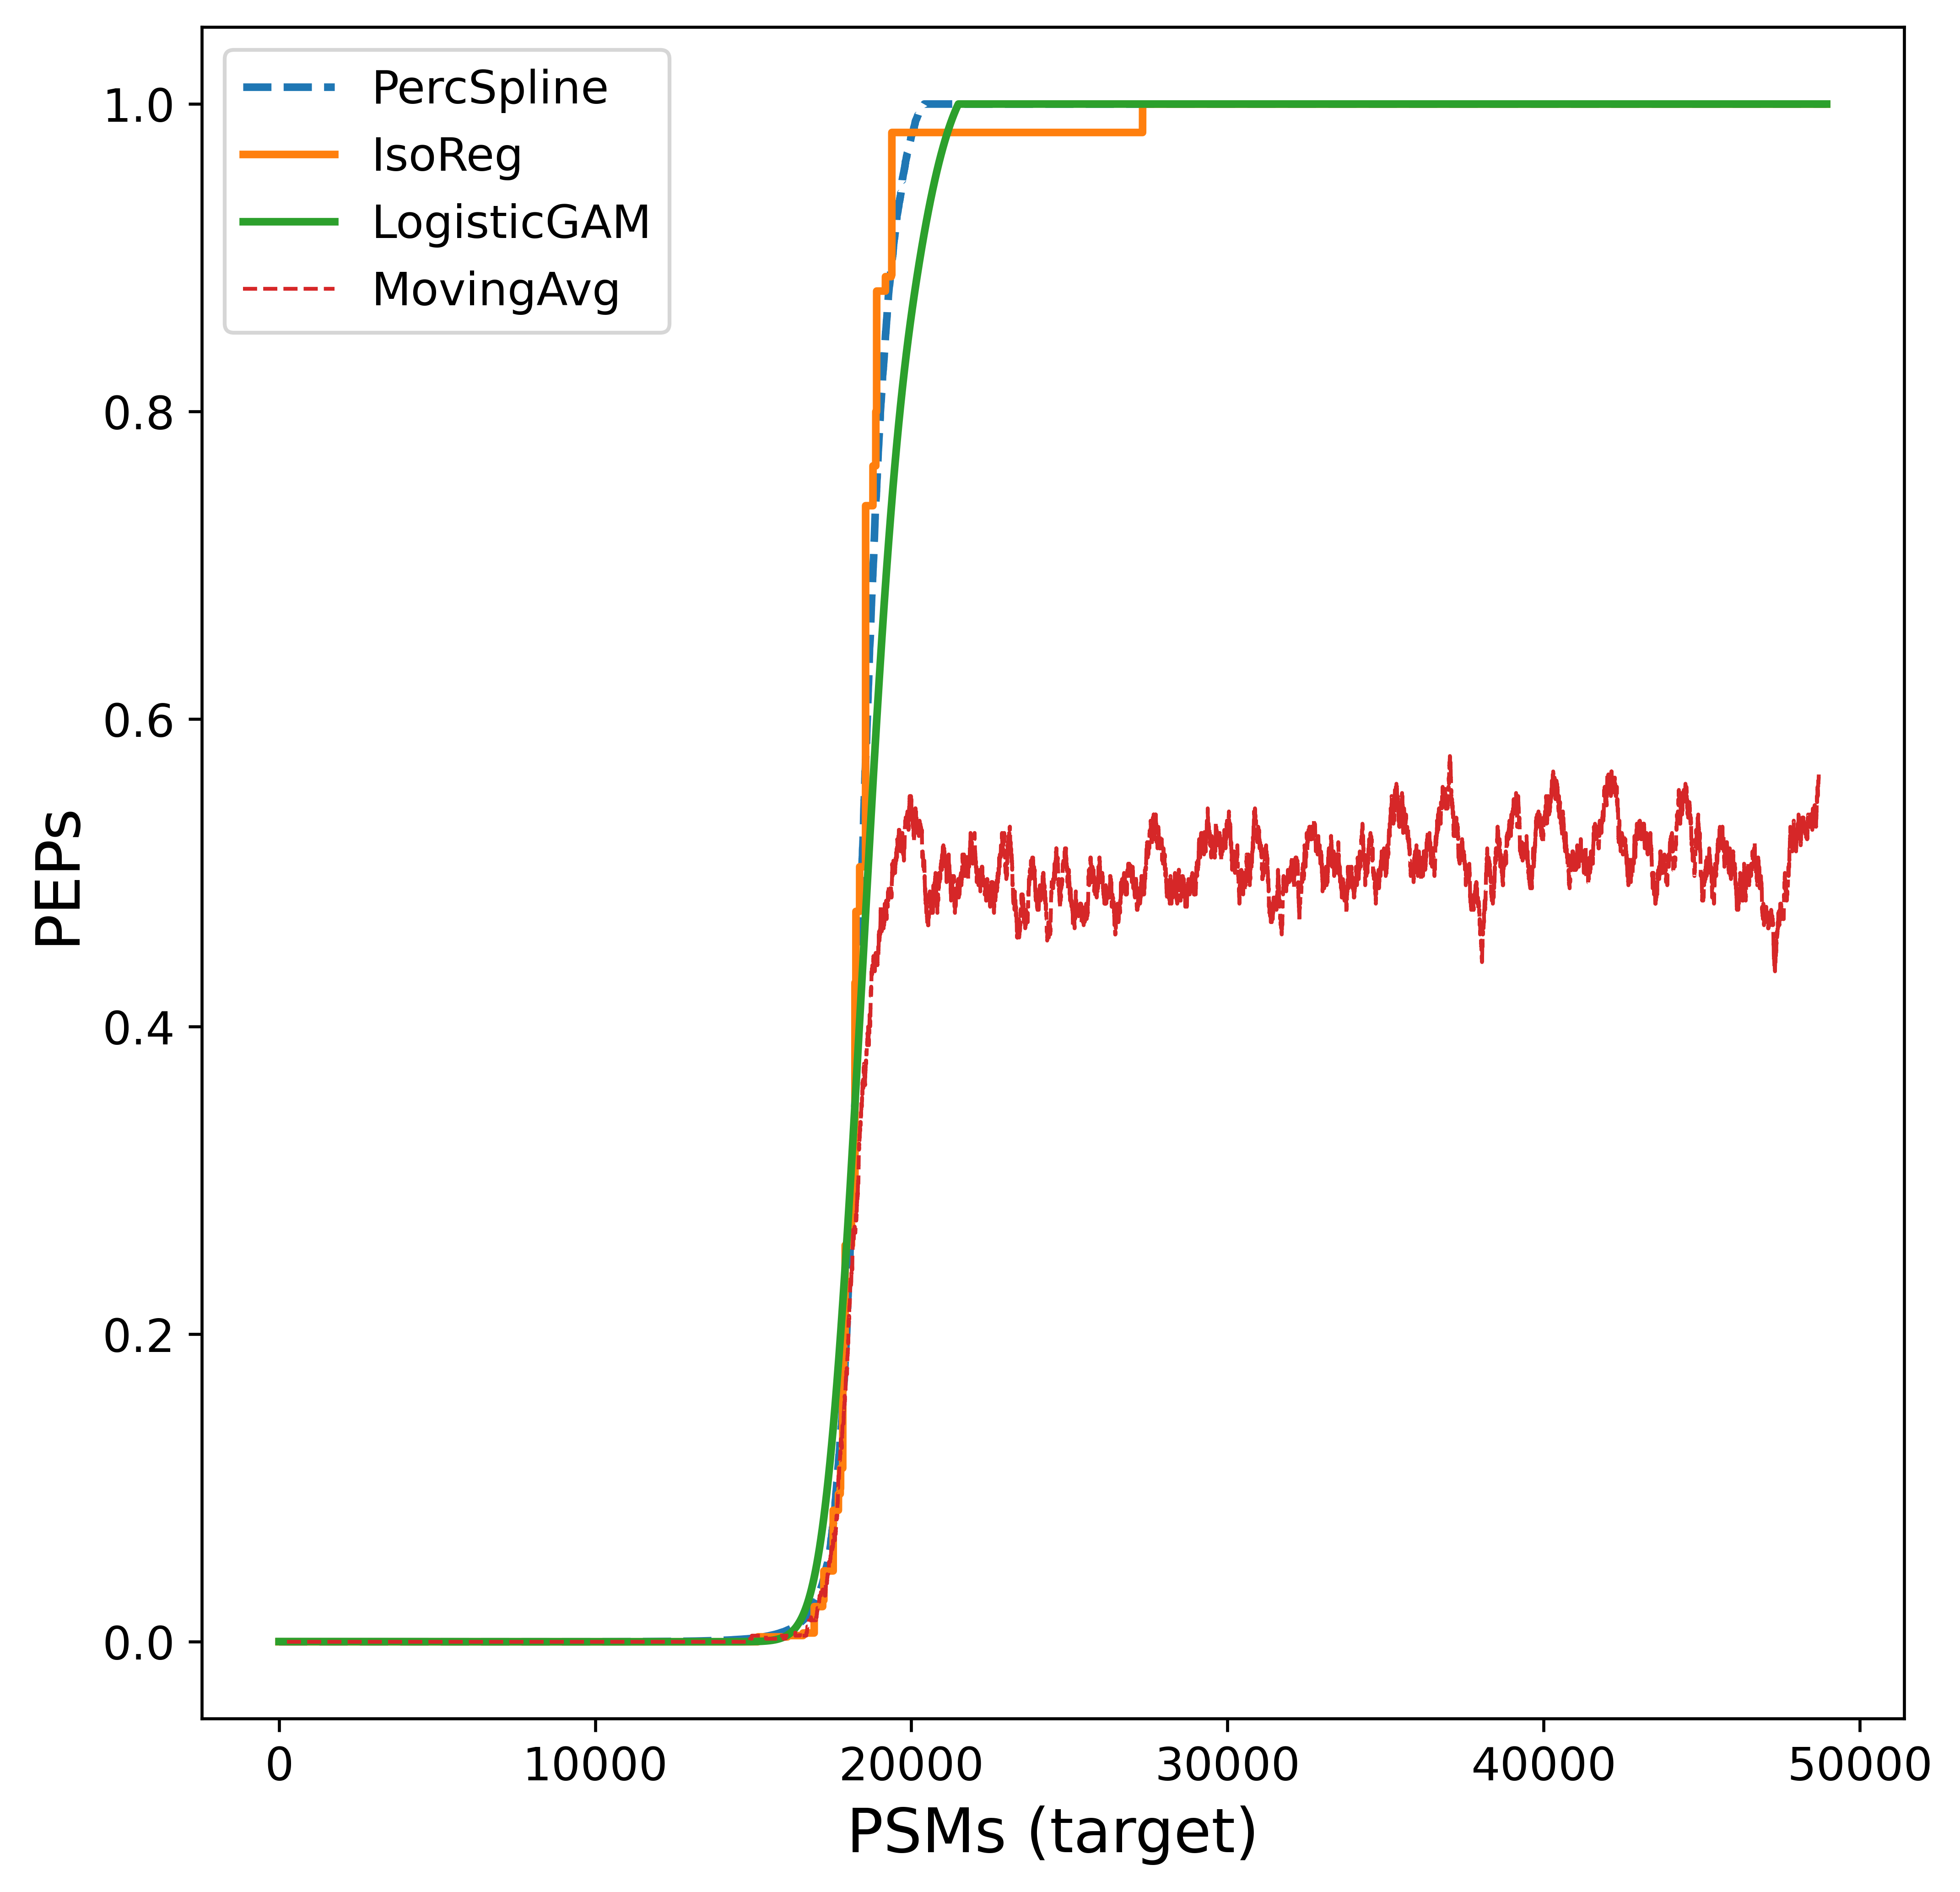

In [91]:
plt.figure(figsize=(8, 8), dpi=600)
xx = np.array(range(len(df["score"])))
plt.plot(xx, df["pep_percspline"], label="PercSpline", linewidth=2, linestyle="--")
plt.plot(xx, df["pep_isoreg"], label="IsoReg", linewidth=2)
plt.plot(xx, df["pep_logisticgam"], label="LogisticGAM", linewidth=2)
plt.plot(xx, y_moving_avg, label="MovingAvg", linewidth=1, linestyle="--")
plt.xlabel("PSMs (target)", fontsize=16)
plt.ylabel("PEPs", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [92]:
def estimate_q(df, col):
    df.index += 1
    df[f"q_{col}"] = df[f"pep_{col}"].cumsum() / df.index
    return df
df = df[df["type"] == 0]
df = estimate_q(df, "isoreg")
df = estimate_q(df, "logisticgam")
df = estimate_q(df, "percspline")

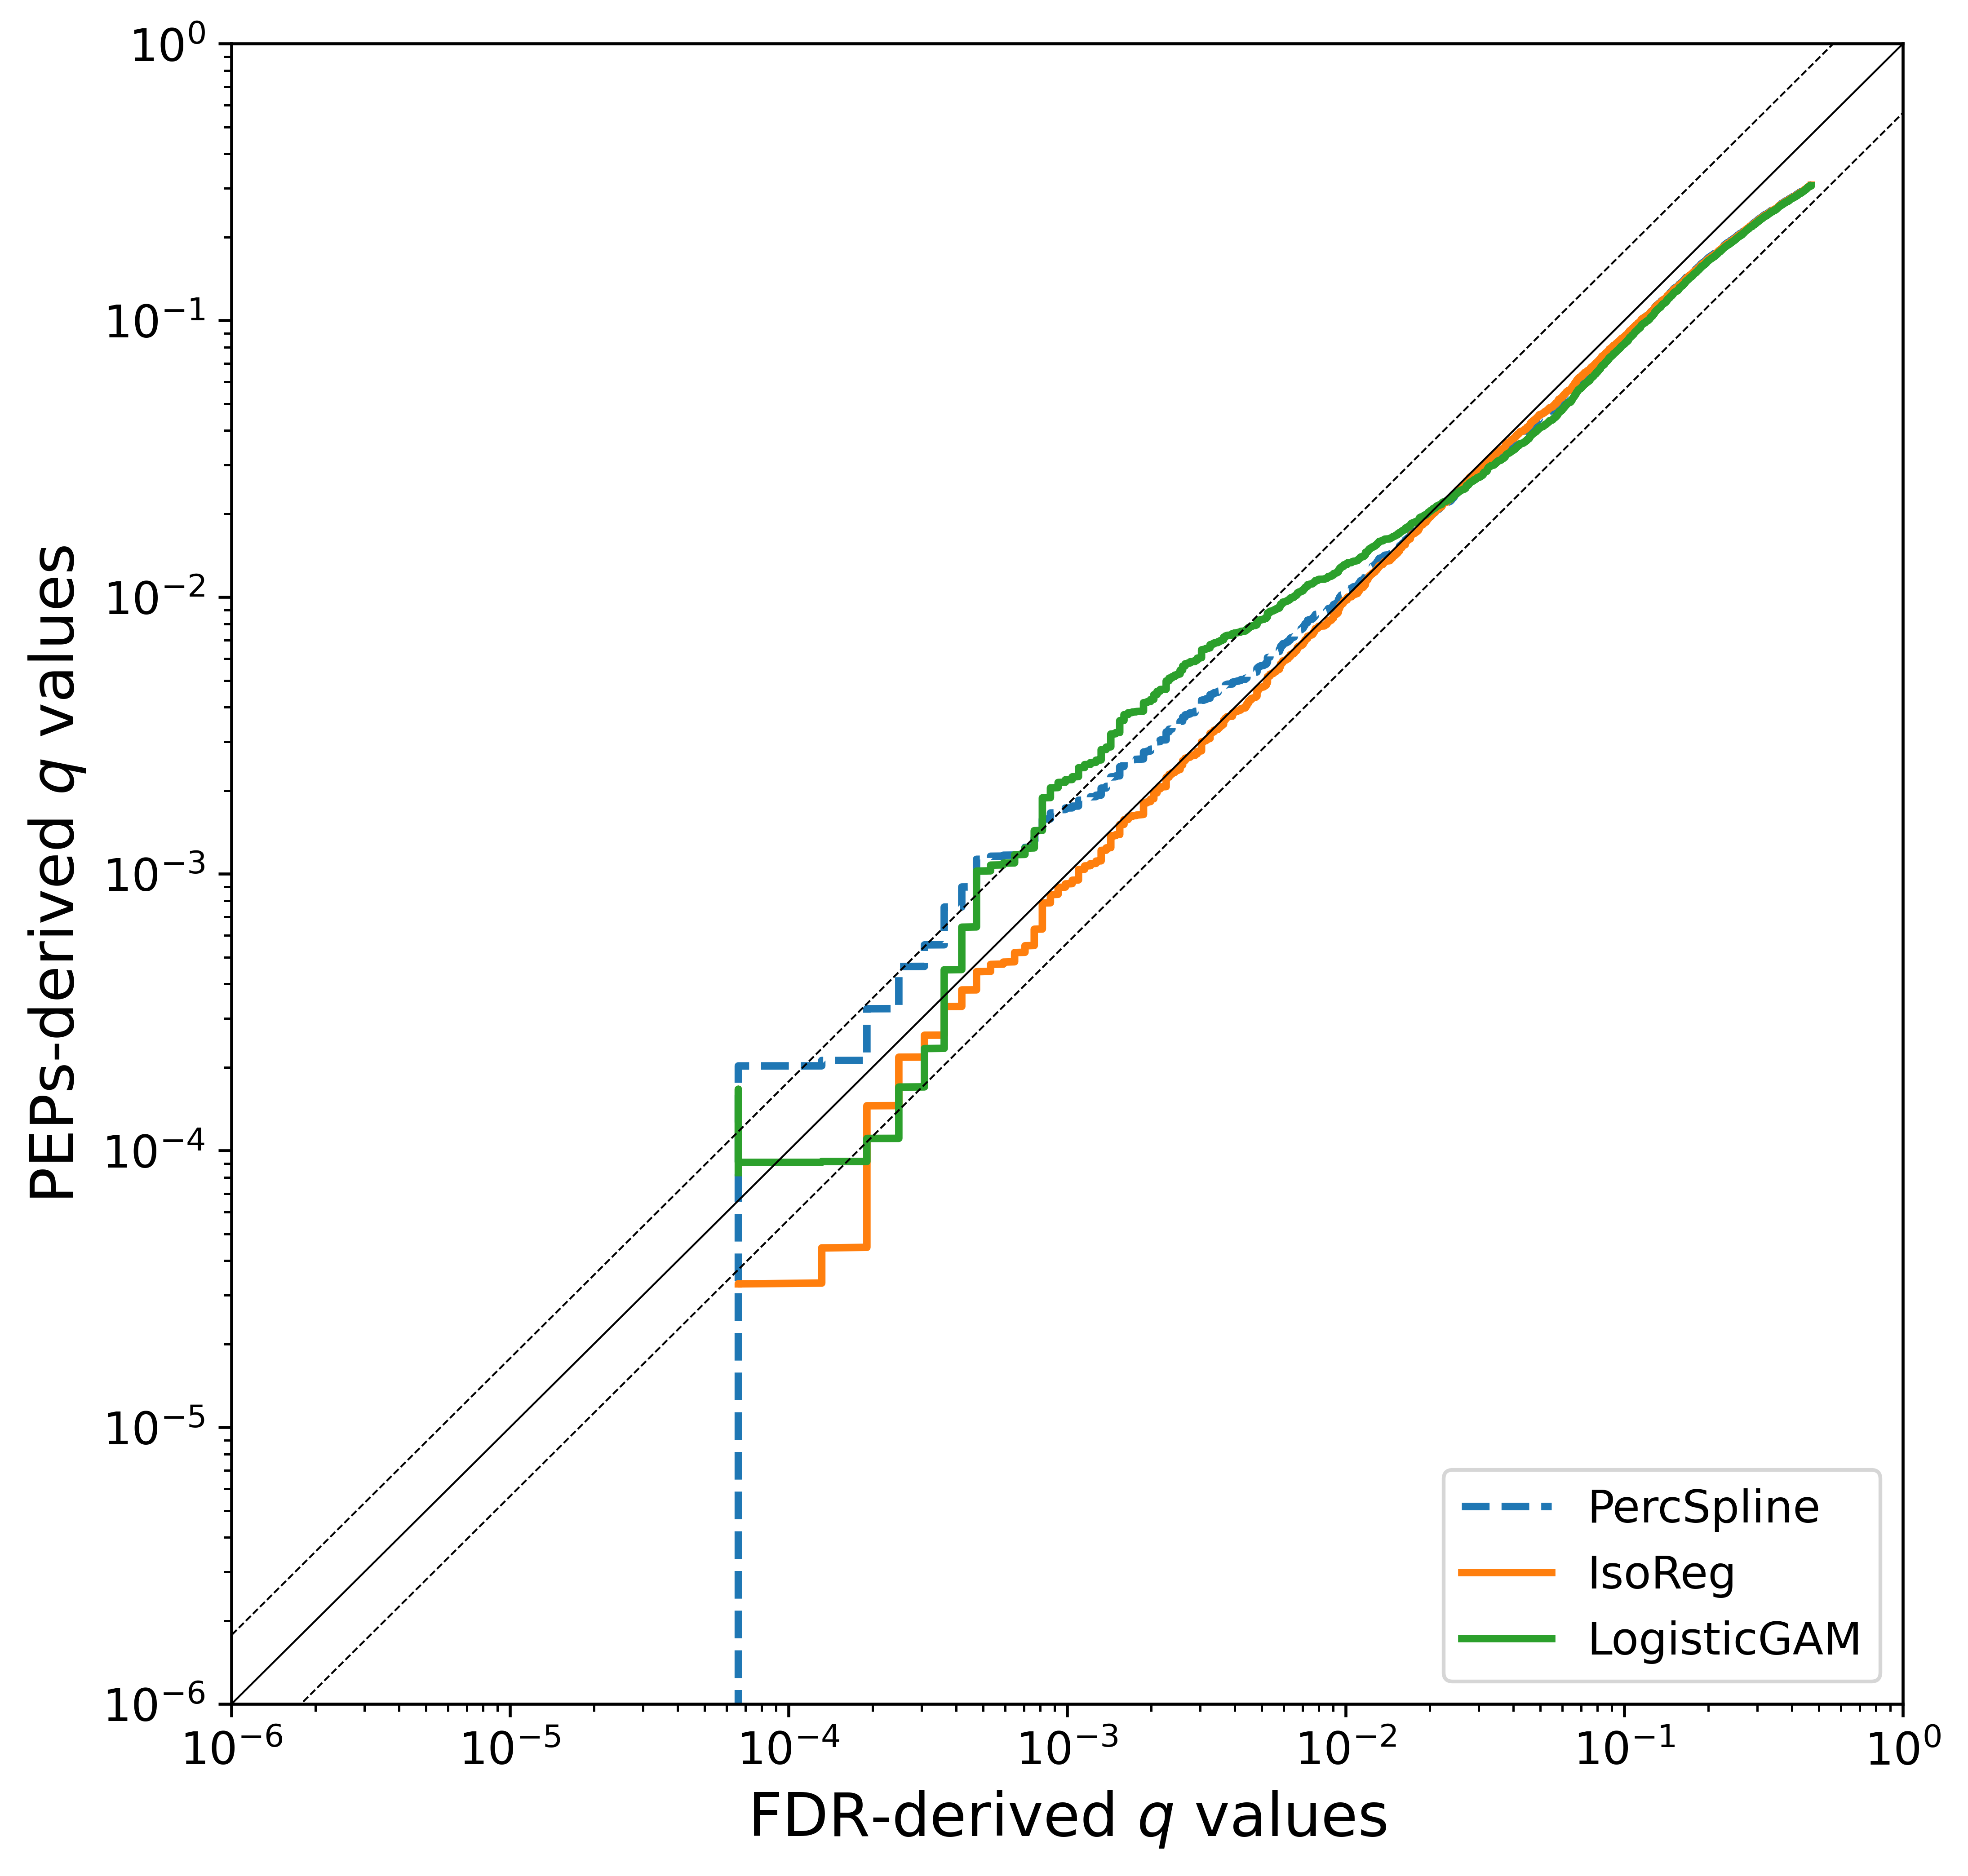

In [93]:
plt.figure(figsize=(8, 8), dpi=600)
plt.plot(df["q-value"], df[f"q_percspline"], label="PercSpline", linewidth=2, linestyle="--")
plt.plot(df["q-value"], df[f"q_isoreg"], label="IsoReg", linewidth=2)
plt.plot(df["q-value"], df[f"q_logisticgam"], label="LogisticGAM", linewidth=2)

a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, a, c="k", linewidth=0.5)
plt.xlabel("FDR-derived $q$ values", fontsize=16)
plt.ylabel("PEPs-derived $q$ values", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.000001, 1)
plt.ylim(0.000001, 1)
plt.show()